In [292]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import numpy as np
import pickle
import math

In [293]:
class data_visualisation:
    def __init__(self, df, instance):
        self.df=df
        self.instance=instance
        self.convert_data_types()
        self.dummy_df()
        self.directory="/Users/adslv/Documents/LU/Term 3/Kiwi_TSP_Challenge/Code/Plots test"

    def convert_data_types(self):
        columns_to_convert = [
            "Best node - cost",
            "Time to preprocess the data",
            "Time to find the solution",
            "Total time",
            "Number of SELECTION phases",
            "Number of SIMULATION phases",
            "Number childrens",
            "Ratio expansion",
            "Cp"
        ]

        for column in columns_to_convert:
            self.df[column] = pd.to_numeric(self.df[column], errors='coerce')
        
    def best_result(self):
        # Define the grouping columns
        group_cols = [
            'Instance', 
            'Desired expansion policy', 
            'Desired simulation policy', 
            'Desired selection policy', 
            'Number childrens', 
            'Ratio expansion', 
            'Cp'
        ]
        
        # Group the dataframe by the defined columns
        grouped = self.df.groupby(group_cols)
        
        # Calculate the required statistics for 'Best node - cost'
        statistics = grouped['Best node - cost'].agg([
            ('min', lambda x: x.min() if x.notna().any() else None),
            ('mean', lambda x: round(x.mean(), 2) if x.notna().any() else None),
            ('median', lambda x: x.median() if x.notna().any() else None),
            ('std', lambda x: round(x.std(), 2) if x.notna().any() else None),
            ('count', 'count'),
            ('q1', lambda x: x.quantile(0.25) if x.notna().any() else None),
            ('q3', lambda x: x.quantile(0.75) if x.notna().any() else None)
        ]).reset_index()
        
        # Function to get the row with the minimum 'Best node - cost', handling NaNs
        def get_min_cost_row(group):
            valid_group = group.dropna(subset=['Best node - cost'])
            if not valid_group.empty:
                min_row = valid_group.loc[valid_group['Best node - cost'].idxmin()]
                return min_row[['Best node - cost', 'Time to find the solution']]
            else:
                return pd.Series([None, None], index=['Best node - cost', 'Time to find the solution'])

        # Apply the function to each group and reset the index
        min_cost_rows = grouped.apply(get_min_cost_row).reset_index()

        # Merge the statistics with the minimum cost rows
        final_df = min_cost_rows.merge(statistics, on=group_cols)

        # Select and order the desired columns
        final_df = final_df[['Desired selection policy', 'Desired expansion policy', 'Desired simulation policy',
                            'Number childrens', 'Ratio expansion', 'Cp', 'Best node - cost', 'mean', 'std', 
                            'Time to find the solution']]

        # Replace specific policy names with more readable labels
        final_df['Desired expansion policy'] = final_df['Desired expansion policy'].replace({
            'top_k': 'top k',
            'ratio_k': 'ratio k'
        })
        final_df['Desired simulation policy'] = final_df['Desired simulation policy'].replace({
            'tolerance_policy': 'tolerance',
            'random_policy': 'random',
            "greedy_policy": "greedy"
        })

        valid_output = final_df.dropna(subset=['Best node - cost'])
        invalid_output = final_df[final_df['Best node - cost'].isna()]

        valid_output=valid_output.sort_values(by=['Best node - cost', 'Time to find the solution','mean','std'])
        # Sort the final DataFrame by 'Best node - cost' and 'Time to find the solution'
        return valid_output, invalid_output
    
    def get_latex_old(self):
        latex_str = self.best_result()[0].to_latex(index=False, float_format="{:.1f}".format)

        # Replace \begin{tabular} with \begin{longtable} and similarly for the ending
        latex_str = latex_str.replace("\\begin{tabular}", "\\begin{longtable}")
        latex_str = latex_str.replace("\\end{tabular}", "\\end{longtable}")
        print(latex_str)
        
        latex_str = self.best_result()[1].to_latex(index=False, float_format="{:.1f}".format)

        # Replace \begin{tabular} with \begin{longtable} and similarly for the ending
        latex_str = latex_str.replace("\\begin{tabular}", "\\begin{longtable}")
        latex_str = latex_str.replace("\\end{tabular}", "\\end{longtable}")
        print(latex_str)
        
    def get_latex(self):
        # First, get the best results DataFrame
        df = self.best_result()[0]

        # Apply specific formatting to each column
        df['Ratio expansion'] = df['Ratio expansion'].apply(
            lambda x: f"{x:.1f}".lstrip('0').rstrip('0').rstrip('.') if x not in [0, 1] else str(int(x))
        )
        df['Cp'] = df['Cp'].apply(lambda x: f"{x:.1f}".rstrip('0').rstrip('.') if x < 1 else f"{x:.1f}")
        df['Best node - cost'] = df['Best node - cost'].astype(int)
        df['Time to find the solution'] = df['Time to find the solution'].apply(
            lambda x: f"{x:.3f}".lstrip('0') if 0 < x < 1 else f"{x:.3f}"
        )
        df['mean'] = df['mean'].apply(lambda x: f"{x:.2f}")
        df['std'] = df['std'].apply(lambda x: f"{x:.2f}" if pd.notna(x) else '')

        # Convert the DataFrame to LaTeX with custom formatting
        latex_str = df.to_latex(index=False, float_format="{:.1f}".format)

        # Replace \begin{tabular} with \begin{longtable} and similarly for the ending
        latex_str = latex_str.replace("\\begin{tabular}", "\\begin{longtable}")
        latex_str = latex_str.replace("\\end{tabular}", "\\end{longtable}")

        # Print the resulting LaTeX string
        print(latex_str)
        
        # First, get the best results DataFrame
        df = self.best_result()[1]

        # Apply specific formatting to each column
        df['Ratio expansion'] = df['Ratio expansion'].apply(
            lambda x: f"{x:.1f}".lstrip('0').rstrip('0').rstrip('.') if x not in [0, 1] else str(int(x))
        )
        df['Cp'] = df['Cp'].apply(lambda x: f"{x:.1f}".rstrip('0').rstrip('.') if x < 1 else f"{x:.1f}")
        
        # Convert the DataFrame to LaTeX with custom formatting
        latex_str = df.to_latex(index=False, float_format="{:.1f}".format)

        # Replace \begin{tabular} with \begin{longtable} and similarly for the ending
        latex_str = latex_str.replace("\\begin{tabular}", "\\begin{longtable}")
        latex_str = latex_str.replace("\\end{tabular}", "\\end{longtable}")

        # Print the resulting LaTeX string
        print(latex_str)
    
    def dummy_df(self):
        # Step 1: Create a DataFrame with the relevant columns
        df = self.df[[
            "Best node - cost",
            "Time to find the solution",
            "Number of SELECTION phases",
            "Number of SIMULATION phases",
            "Cp",
            "Number childrens",
            "Ratio expansion",
            "Desired expansion policy",
            "Desired simulation policy",
            "Desired selection policy"
        ]]
        
        
        self.df_dummies = pd.get_dummies(df, columns=[ "Cp",
                                                    "Number childrens",
                                                    "Ratio expansion",
                                                    "Desired expansion policy",
                                                    "Desired simulation policy",
                                                    "Desired selection policy"], 
                                                    drop_first=False)
        
    def summarise_and_plot(self):

        # Define the parameters to plot
        parameters = ['Cp', 'Number childrens', 'Desired expansion policy', 'Desired simulation policy', 'Desired selection policy',"Ratio expansion"]

        # Calculate figure size based on the number of parameters
        num_params = len(parameters)
        fig_width = 6 * num_params  # 6 units width per parameter
        fig_height = 6  # Keep the height fixed for each row

        # Plotting Time to Find Solution vs parameters in the first row
        plt.figure(figsize=(fig_width, fig_height * 2))

        for i, param in enumerate(parameters):
            plt.subplot(2, num_params, i + 1)  # First row
            sns.violinplot(x=param, y='Time to find the solution', data=self.df, inner="quartile", split=True)
            plt.title(f'Time to Find Solution vs {param}')
            plt.xlabel(param)
            plt.ylabel('Time to Find Solution (seconds)')

        # Plotting Total Cost vs parameters in the second row
        for i, param in enumerate(parameters):
            plt.subplot(2, num_params, i + 1 + num_params)  # Second row
            sns.violinplot(x=param, y='Best node - cost', data=self.df, inner="quartile", split=True)
            plt.title(f'Total Cost vs {param}')
            plt.xlabel(param)
            plt.ylabel('Total Cost')

        plt.tight_layout()
        plt.show()
        
    def cp_vs_cost(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Cp",
                    y="Best node - cost",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Cp vs Total Cost by Selection Policy - Instance {int(self.instance)}")
        plt.xlabel("Cp Value")
        plt.ylabel("Total Cost")
        plt.tight_layout()
        
        plt.savefig(f"{self.directory}/{int(self.instance)} - cp_vs_cost")
        
        plt.show()
        
    def cp_vs_time(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Cp",
                    y="Time to find the solution",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Cp vs Time to find the solution by Selection Policy - Instance {self.instance}")
        plt.xlabel("Cp Value")
        plt.ylabel("Time to find the solution (s)")
        plt.tight_layout()
        plt.savefig(f"{self.directory}/{int(self.instance)} - cp_vs_time")
        
        plt.show()
    
    def cp_vs_selection(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Cp",
                    y="Number of SELECTION phases",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Cp vs Number of selection by Selection Policy - Instance {self.instance}")
        plt.xlabel("Cp Value")
        plt.ylabel("Number of selection")
        plt.tight_layout()
        
        plt.savefig(f"{self.directory}/{int(self.instance)} - cp_vs_selection")
        
        plt.show()
        
    def ratio_vs_cost(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Ratio expansion",
                    y="Best node - cost",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Ratio expansion vs Total cost by Selection Policy - Instance {int(self.instance)}")
        plt.xlabel("Ratio expansion")
        plt.ylabel("Total cost")
        plt.tight_layout()
        plt.savefig(f"{self.directory}/{int(self.instance)} - ratio_vs_cost")

        plt.show()
        
    def ratio_vs_time(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Ratio expansion",
                    y="Time to find the solution",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Ratio expansion vs Total cost by Selection Policy - Instance {int(self.instance)}")
        plt.xlabel("Ratio expansion")
        plt.ylabel("Time to find the solution (s)")
        plt.tight_layout()
        plt.savefig(f"{self.directory}/{int(self.instance)} - ratio_vs_time")

        plt.show()
        
    def expansion_vs_time(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired expansion policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Ratio expansion",
                    y="Time to find the solution",
                    hue="Desired expansion policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Ratio expansion vs Total cost by Expansion Policy - Instance {int(self.instance)}")
        plt.xlabel("Ratio expansion")
        plt.ylabel("Time to find the solution (s)")
        plt.tight_layout()
        plt.savefig(f"{self.directory}/{int(self.instance)} - expansion_vs_time")

        plt.show()
        
    def expansion_vs_cost(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired expansion policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Ratio expansion",
                    y="Best node - cost",
                    hue="Desired expansion policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Ratio expansion vs Total cost by Expansion Policy - Instance {int(self.instance)}")
        plt.xlabel("Ratio expansion")
        plt.ylabel("Total cost")
        plt.tight_layout()
        plt.savefig(f"{self.directory}/{int(self.instance)} - expansion_vs_cost")

        plt.show()
        
    def simulation_vs_cost(self):
        
        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired expansion policy'].unique()))

        plt.figure(figsize=(14, 8))
        sns.boxplot(data=self.df,  # Ensure to use df_instance
                    x="Ratio expansion",
                    y="Best node - cost",
                    hue="Desired simulation policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Ratio expansion vs Total cost by Simulation Policy - Instance {int(self.instance)}")
        plt.xlabel("Ratio expansion")
        plt.ylabel("Total cost")
        plt.tight_layout()
        plt.savefig(f"{self.directory}/{int(self.instance)} - simulation_vs_cost")

        plt.show()
        
    def number_selection_vs_cp(self):

        palette = sns.color_palette("pastel", n_colors=len(self.df['Desired selection policy'].unique()))

        plt.figure(figsize=(16, 8))
        sns.violinplot(data=self.df,  # Ensure to use df_instance
                    x="Cp",
                    y="Number of SELECTION phases",
                    hue="Desired selection policy",
                    palette=palette)  # Apply the pastel palette

        plt.title(f"Cp vs Number of selection by Selection Policy - Instance {self.instance}")
        plt.xlabel("Cp Value")
        plt.ylabel("Number of selection")
        plt.tight_layout()
        plt.show()
         
    def correlation_matrix_old(self):
        
        filtered_df = self.df_dummies[self.df_dummies["Best node - cost"].notna()]

        # Compute the correlation matrix on the filtered DataFrame
        corr_matrix = filtered_df.corr()
        
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

        cmap = sns.diverging_palette(230, 20, as_cmap=True)

        plt.figure(figsize=(14, 14))
        sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True, fmt=".2f")
        
        plt.xticks(rotation=30, ha='right')
        plt.title(f'Correlation Matrix - Instance {int(self.instance)}')
        plt.savefig(f"{self.directory}/{int(self.instance)} - correlation_matrix")
        plt.tight_layout()
        plt.show()
        
        #return corr_matrix
    
    def correlation_matrix(self, column_dict=None):
        """
        Plots the correlation matrix for the given DataFrame based on the provided column dictionary.
        
        Parameters:
        column_dict (dict, optional): Dictionary mapping column names to 0 or 1. 
                                    If 1, the column is included in the correlation matrix.
                                    If None, the entire correlation matrix is plotted.
        """
        # Filter the DataFrame to include only rows where "Best node - cost" is not NaN
        filtered_df = self.df_dummies[self.df_dummies["Best node - cost"].notna()]

        # If a column_dict is provided, filter columns based on the dictionary
        if column_dict is not None:
            selected_columns = [col for col, include in column_dict.items() if include == 1]
            filtered_df = filtered_df[selected_columns]

        # Compute the correlation matrix on the filtered DataFrame
        corr_matrix = filtered_df.corr()
        
        # Generate a mask for the upper triangle
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

        # Set up the matplotlib figure
        plt.figure(figsize=(14, 14))
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        
        # Draw the heatmap with the mask and correct aspect ratio
        sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
                    square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")
        
        # Rotate the x-axis labels for better readability
        plt.xticks(rotation=30, ha='right')

        # Set the title
        plt.title(f'Correlation Matrix - Instance {int(self.instance)}')

        # Save the figure
        plt.savefig(f"{self.directory}/{int(self.instance)} - correlation_matrix")

        # Adjust layout to fit everything neatly
        plt.tight_layout()

        # Show the plot
        plt.show()

    def multi_variable_scatter(self):            
        sns.pairplot(self.df, 
                    vars=["Cp", "Best node - cost", "Total time","Number of SELECTION phases","Number of SIMULATION phases"], 
                    hue="Desired selection policy", 
                    palette="pastel", 
                    markers=["o", "s", "D", "^"], 
                    plot_kws={'alpha': 0.5})
        plt.suptitle(f'Multi-variable Analysis for Instance {self.instance}', y=1.02)
        plt.show()
        
    def plot_different_time_complexity(self):
        complexities = {
            'O(1)': np.ones(1000),  # Constant time, repeated for visualization purposes
            'O(log n)': np.log(np.arange(1, 1001)),  # Logarithmic time
            'O(n)': np.arange(1, 1001),  # Linear time
            'O(n log n)': np.arange(1, 1001) * np.log(np.arange(1, 1001)),  # Linearithmic time
            'O(n^2)': np.arange(1, 1001) ** 2,  # Quadratic time
            'O(2^n)': 2 ** np.arange(1, 23),  # Exponential time
            'O(n!)': np.array([math.factorial(i) for i in range(1, 11)])  # Factorial time
        }

        # Manual selection of colors for better visibility
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

        plt.figure(figsize=(14, 8))

        for i, (label, complexity) in enumerate(complexities.items()):
            x_values = np.arange(1, len(complexity) + 1)
            plt.plot(x_values, complexity, label=label, color=colors[i])

        plt.yscale('log')  # Use log scale for better visualization
        plt.xscale('log')  # Use log scale to better visualize large ranges

        plt.xlabel('Input size - n')
        plt.ylabel('Number of Opations')
        plt.title('Comparison of Time Complexities for different functions')
        plt.legend(loc='upper left')
        plt.savefig(f"{self.directory}/Time_complexities")
        
        plt.show()
        

### Load dataframes

In [294]:
data_1=pd.read_csv("/Users/adslv/Documents/LU/Term 3/Kiwi_TSP_Challenge/Code/Pickle 1 and 2/1_combined.csv")

In [295]:
with open("/Users/adslv/Documents/LU/Term 3/Kiwi_TSP_Challenge/Code/Pickle 1 and 2/2_all.pkl", "rb") as file:
    data_2 = pickle.load(file)

In [296]:
with open("/Users/adslv/Documents/LU/Term 3/Kiwi_TSP_Challenge/Code/Pickle 1 and 2/1_tolerance.pkl", "rb") as file111:
    data_1_tolerance = pickle.load(file111)

### Analysis

In [297]:
DV=data_visualisation(df=data_2, instance="2")

In [298]:
DV.df_dummies.columns

Index(['Best node - cost', 'Time to find the solution',
       'Number of SELECTION phases', 'Number of SIMULATION phases', 'Cp_0.0',
       'Cp_1.41', 'Cp_2.82', 'Number childrens_5', 'Number childrens_10',
       'Number childrens_15', 'Ratio expansion_0.0', 'Ratio expansion_0.3',
       'Ratio expansion_0.5', 'Ratio expansion_0.8', 'Ratio expansion_1.0',
       'Desired expansion policy_ratio_k', 'Desired expansion policy_top_k',
       'Desired simulation policy_greedy_policy',
       'Desired simulation policy_random_policy',
       'Desired simulation policy_tolerance_policy',
       'Desired selection policy_UCB', 'Desired selection policy_UCB1T'],
      dtype='object')

In [299]:
DV.get_latex()

/var/folders/j7/pm3l9xwx0w5d65kp68nzsdz40000gn/T/ipykernel_11365/1492477746.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_cost_rows = grouped.apply(get_min_cost_row).reset_index()


\begin{longtable}{lllrllrlll}
\toprule
Desired selection policy & Desired expansion policy & Desired simulation policy & Number childrens & Ratio expansion & Cp & Best node - cost & mean & std & Time to find the solution \\
\midrule
UCB & ratio k & greedy & 5 & .8 & 0 & 1498 & 1498.00 &  & .082 \\
UCB & ratio k & greedy & 5 & .3 & 1.4 & 1498 & 1498.00 &  & .083 \\
UCB1T & ratio k & greedy & 10 & 1 & 1.4 & 1498 & 1498.00 &  & .084 \\
UCB1T & ratio k & greedy & 15 & .5 & 0 & 1498 & 1498.00 &  & .087 \\
UCB & ratio k & greedy & 5 & .8 & 1.4 & 1498 & 1498.00 &  & .087 \\
UCB & ratio k & greedy & 15 & .3 & 2.8 & 1498 & 1498.00 &  & .087 \\
UCB & ratio k & greedy & 15 & 0 & 2.8 & 1498 & 1498.00 &  & .088 \\
UCB1T & ratio k & greedy & 15 & 0 & 1.4 & 1498 & 1498.00 &  & .088 \\
UCB & top k & tolerance & 10 & 0 & 2.8 & 1498 & 1498.00 & 0.00 & .089 \\
UCB1T & ratio k & greedy & 10 & 1 & 2.8 & 1498 & 1498.00 &  & .089 \\
UCB & ratio k & greedy & 10 & .5 & 2.8 & 1498 & 1498.00 &  & .089 \\
UCB & t

/var/folders/j7/pm3l9xwx0w5d65kp68nzsdz40000gn/T/ipykernel_11365/1492477746.py:61: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  min_cost_rows = grouped.apply(get_min_cost_row).reset_index()


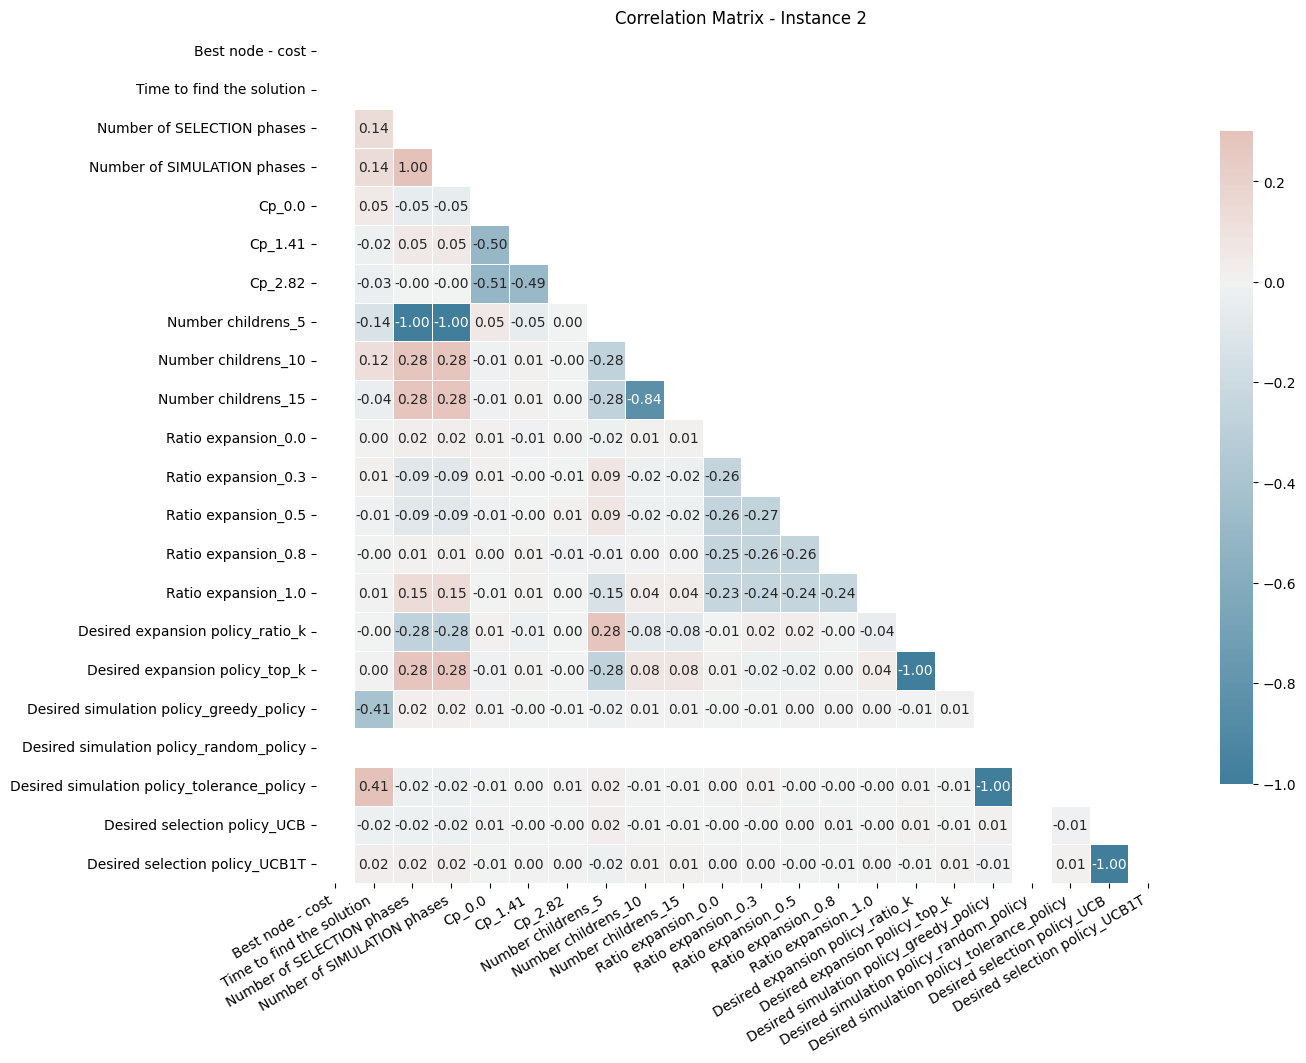

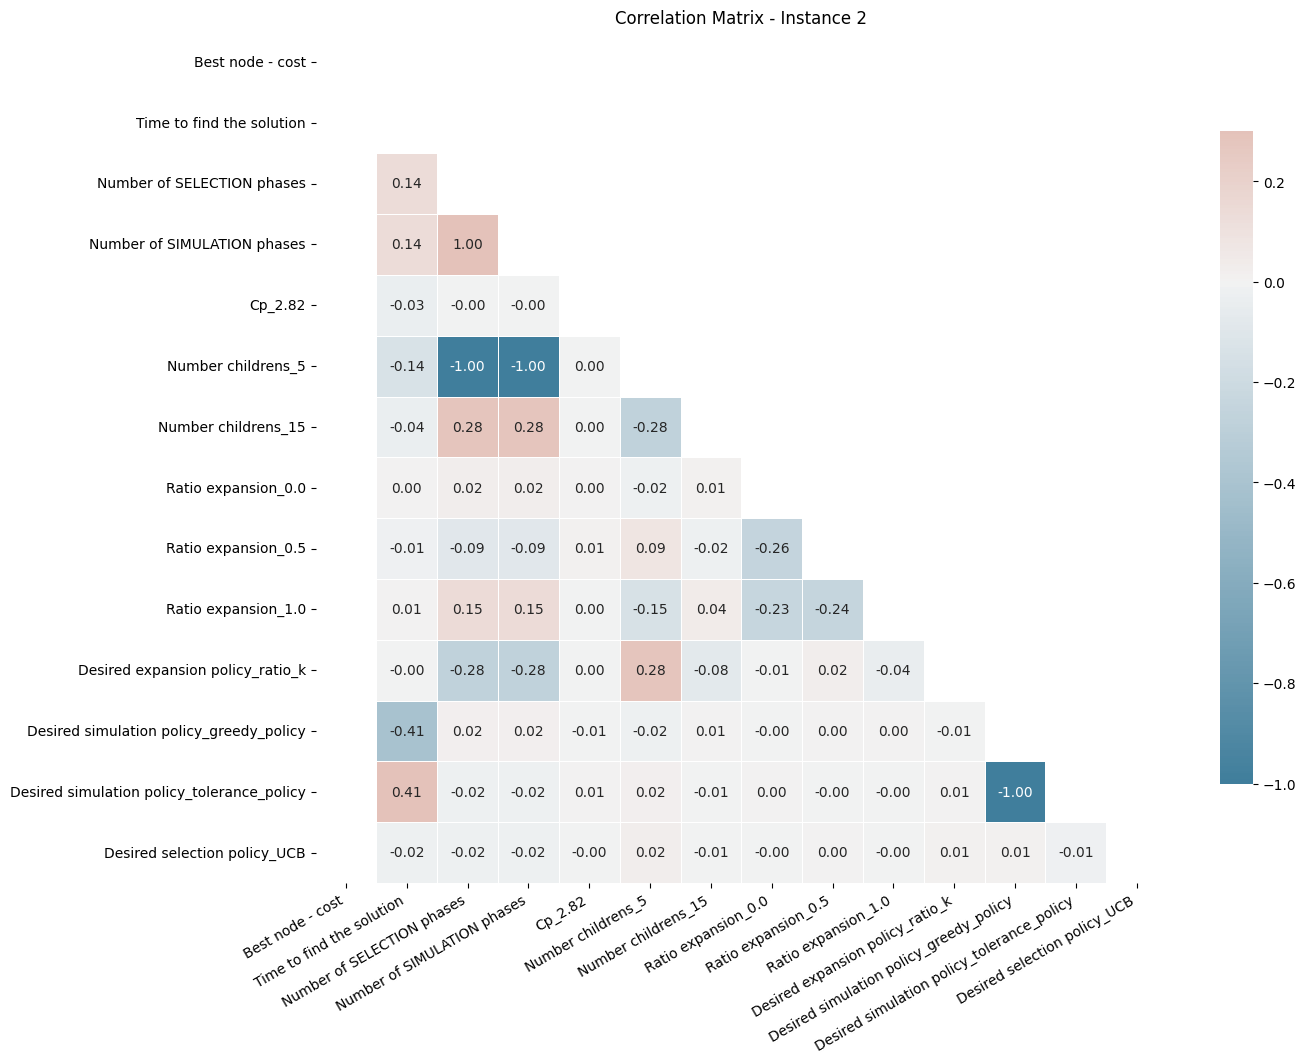

In [300]:
column_dict = {
    'Best node - cost': 1,
    'Time to find the solution': 1,
    'Number of SELECTION phases': 1,
    'Number of SIMULATION phases': 1,
    'Cp_0.0': 0,
    'Cp_1.41': 0,
    'Cp_2.82': 1,
    'Number childrens_5': 1,
    'Number childrens_10': 0,
    'Number childrens_15': 1,
    'Ratio expansion_0.0': 1,
    'Ratio expansion_0.3': 0,
    'Ratio expansion_0.5': 1,
    'Ratio expansion_0.8': 0,
    'Ratio expansion_1.0': 1,
    'Desired expansion policy_ratio_k': 1,
    'Desired expansion policy_top_k': 0,
    'Desired simulation policy_greedy_policy': 1,
    'Desired simulation policy_random_policy': 0,
    'Desired simulation policy_tolerance_policy': 1,
    'Desired selection policy_UCB': 1,
    'Desired selection policy_UCB1T': 0
}
DV.correlation_matrix(column_dict=None)
DV.correlation_matrix(column_dict=column_dict)

/var/folders/j7/pm3l9xwx0w5d65kp68nzsdz40000gn/T/ipykernel_11365/1492477746.py:344: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=self.df,  # Ensure to use df_instance


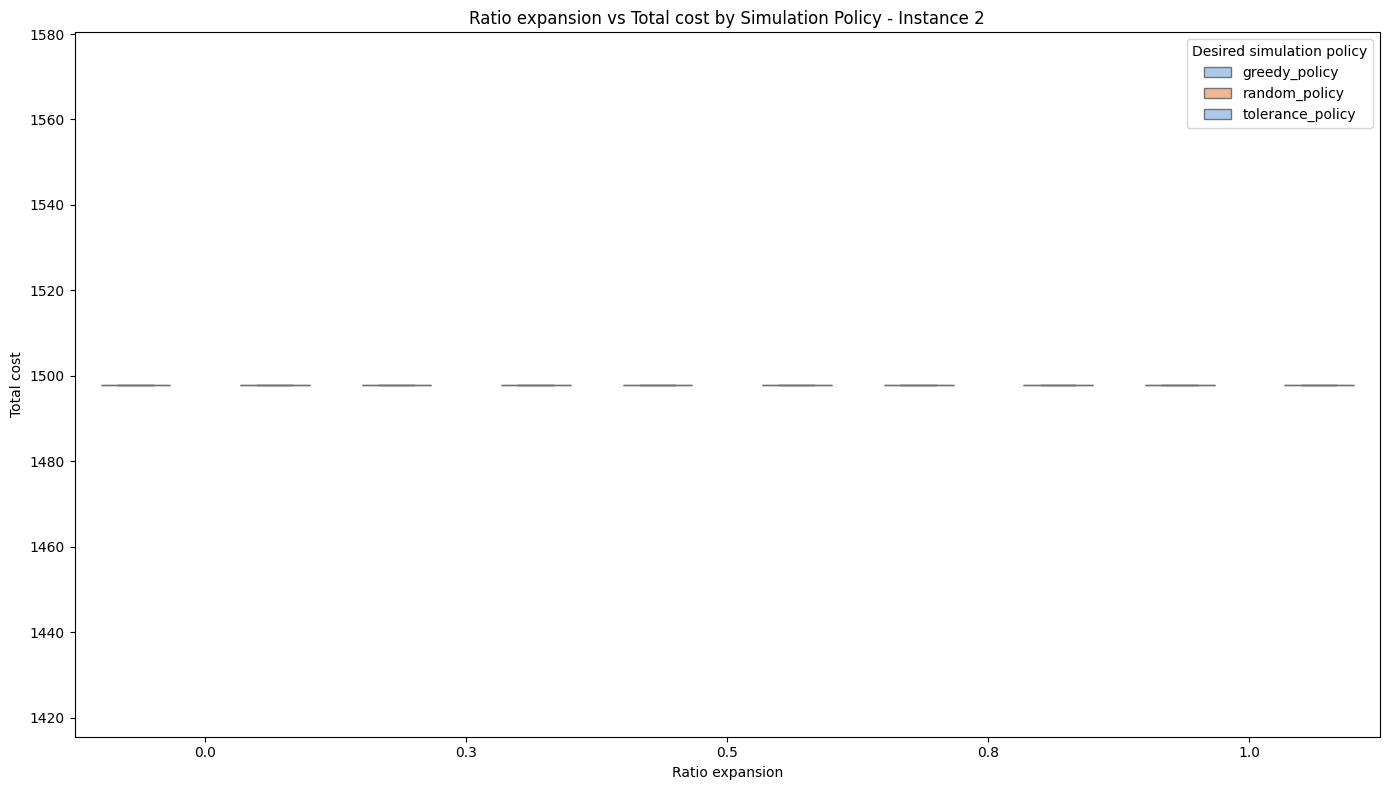

In [301]:
DV.simulation_vs_cost()

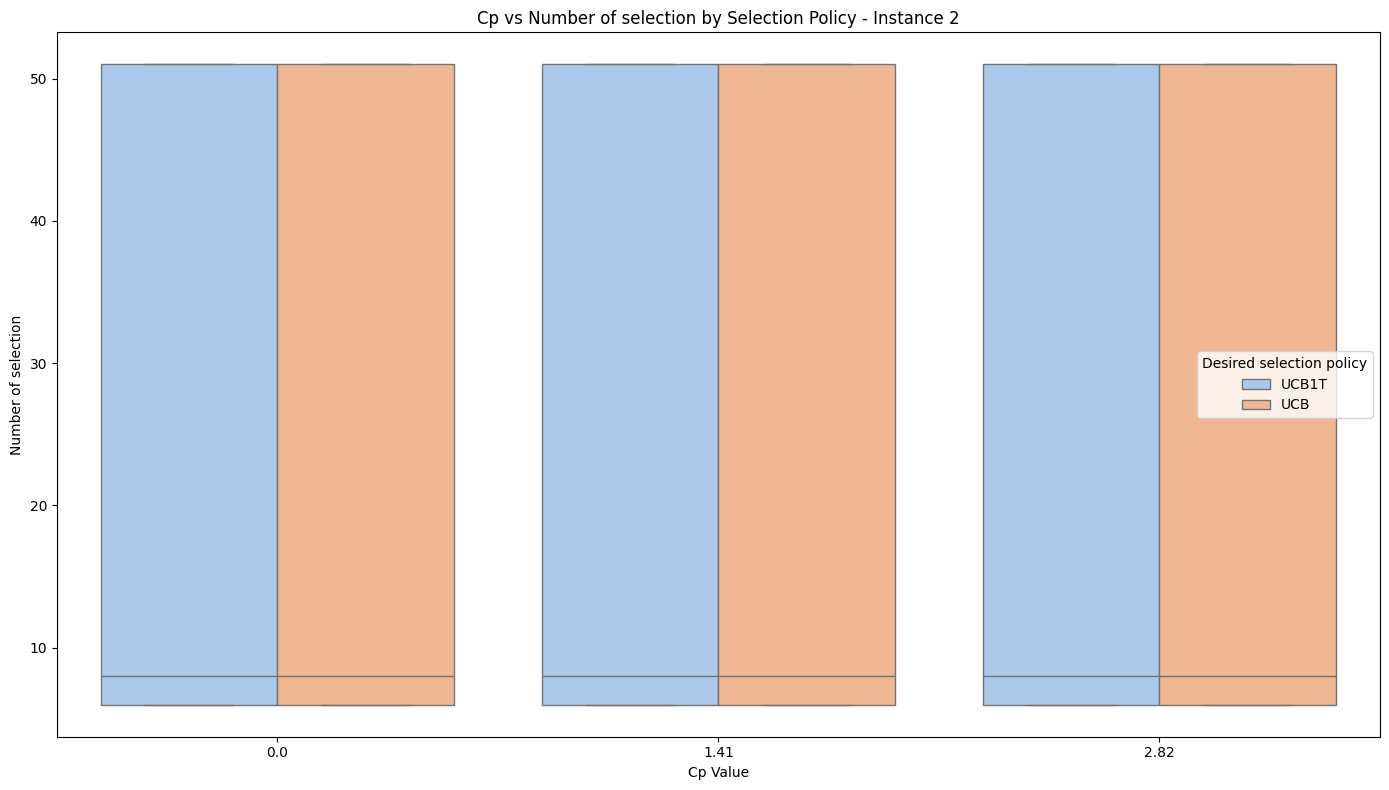

In [302]:
DV.cp_vs_selection()

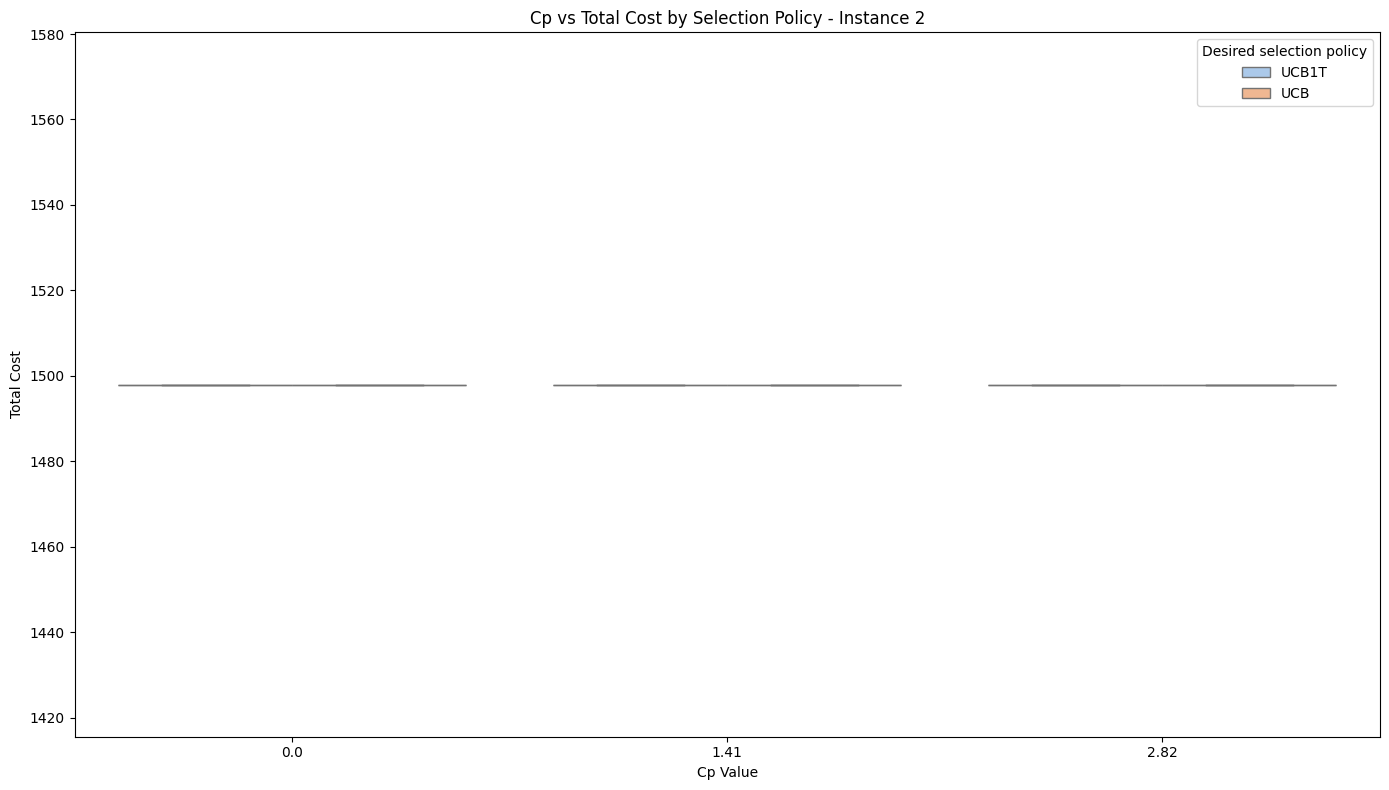

In [303]:
DV.cp_vs_cost()

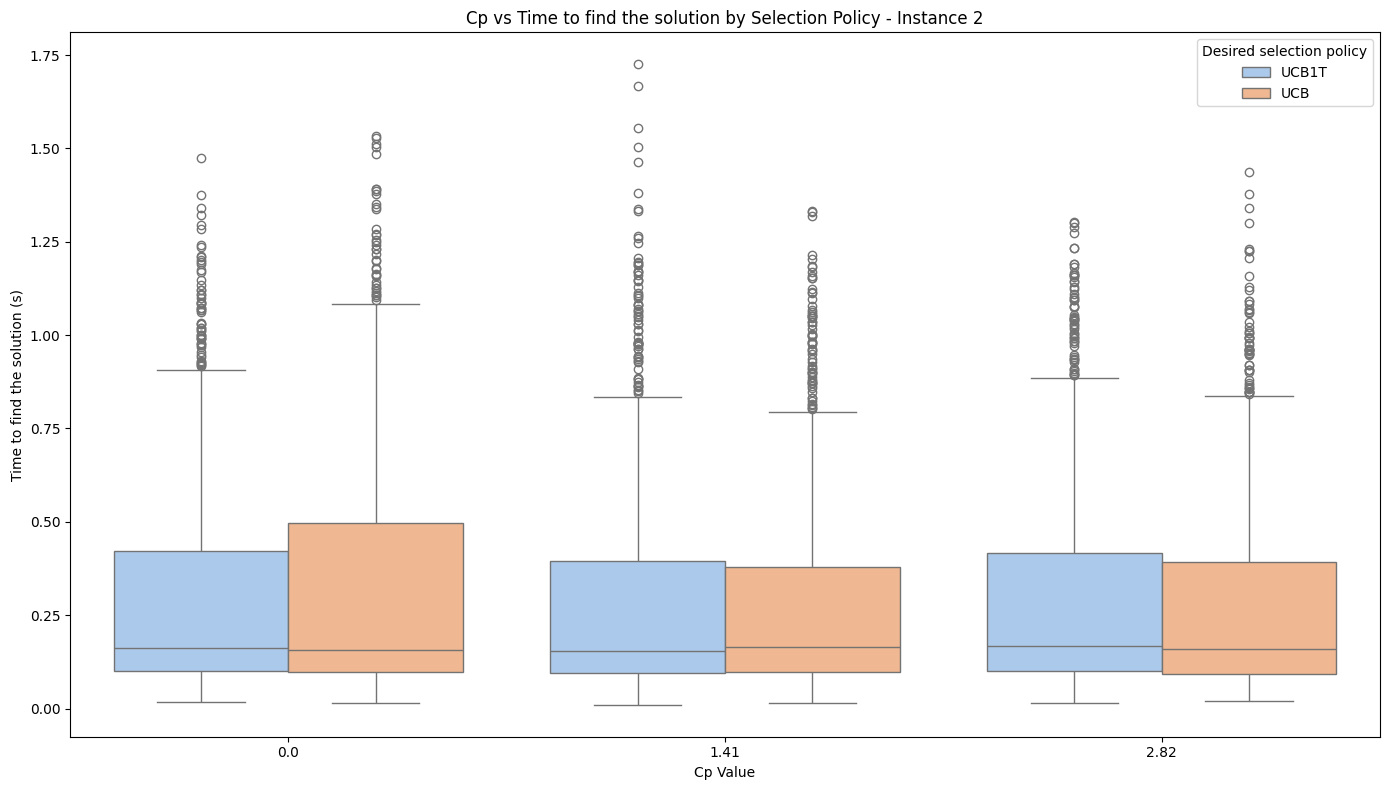

In [304]:
DV.cp_vs_time()

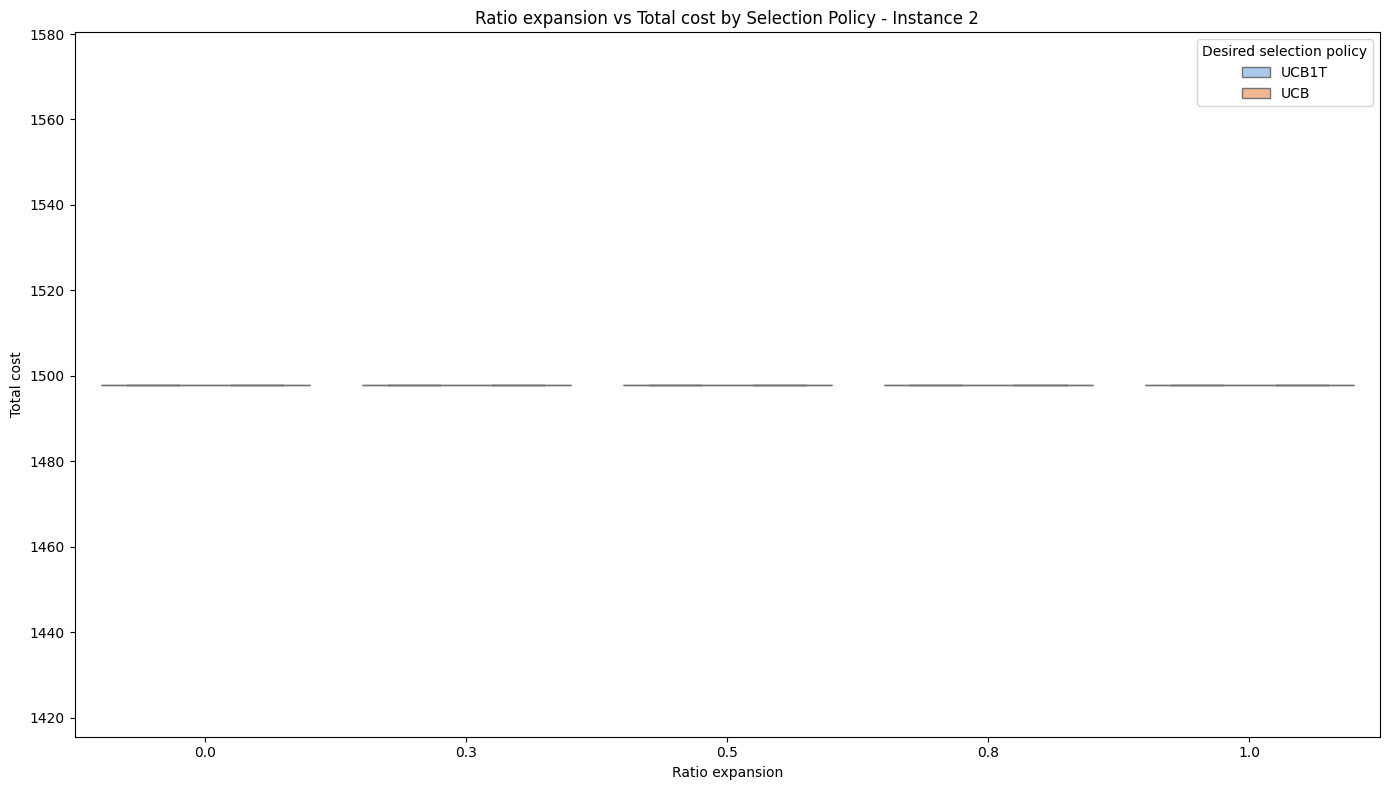

In [305]:
DV.ratio_vs_cost()

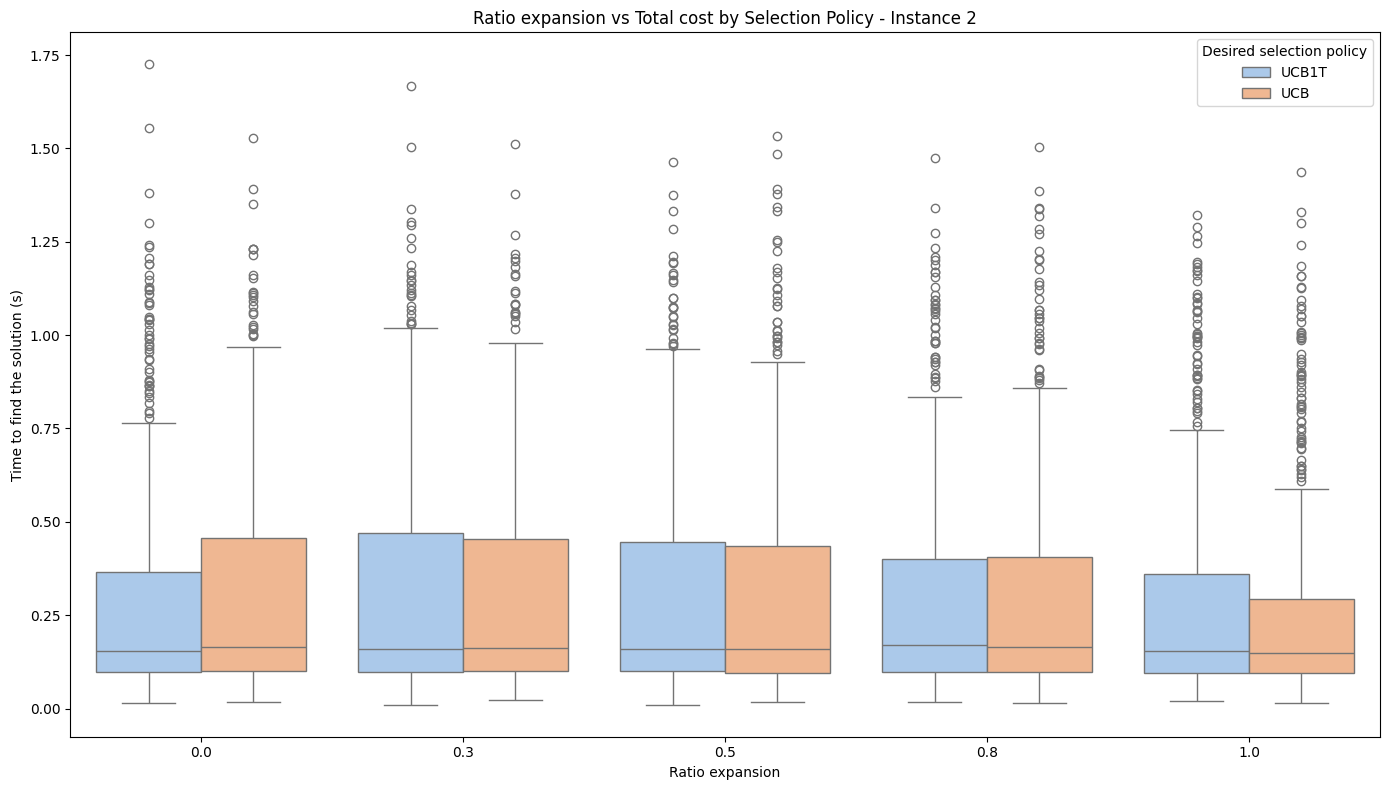

In [306]:
DV.ratio_vs_time()

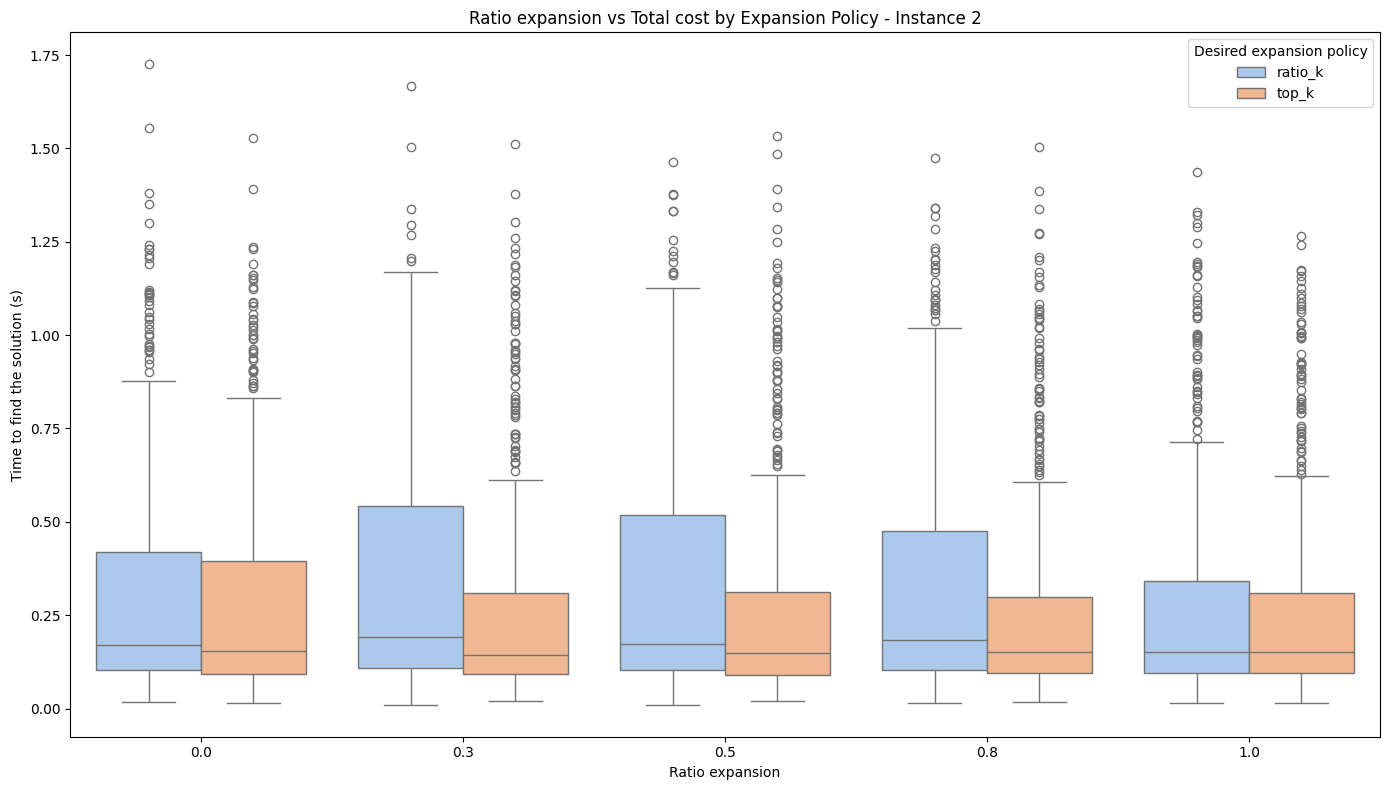

In [307]:
DV.expansion_vs_time()

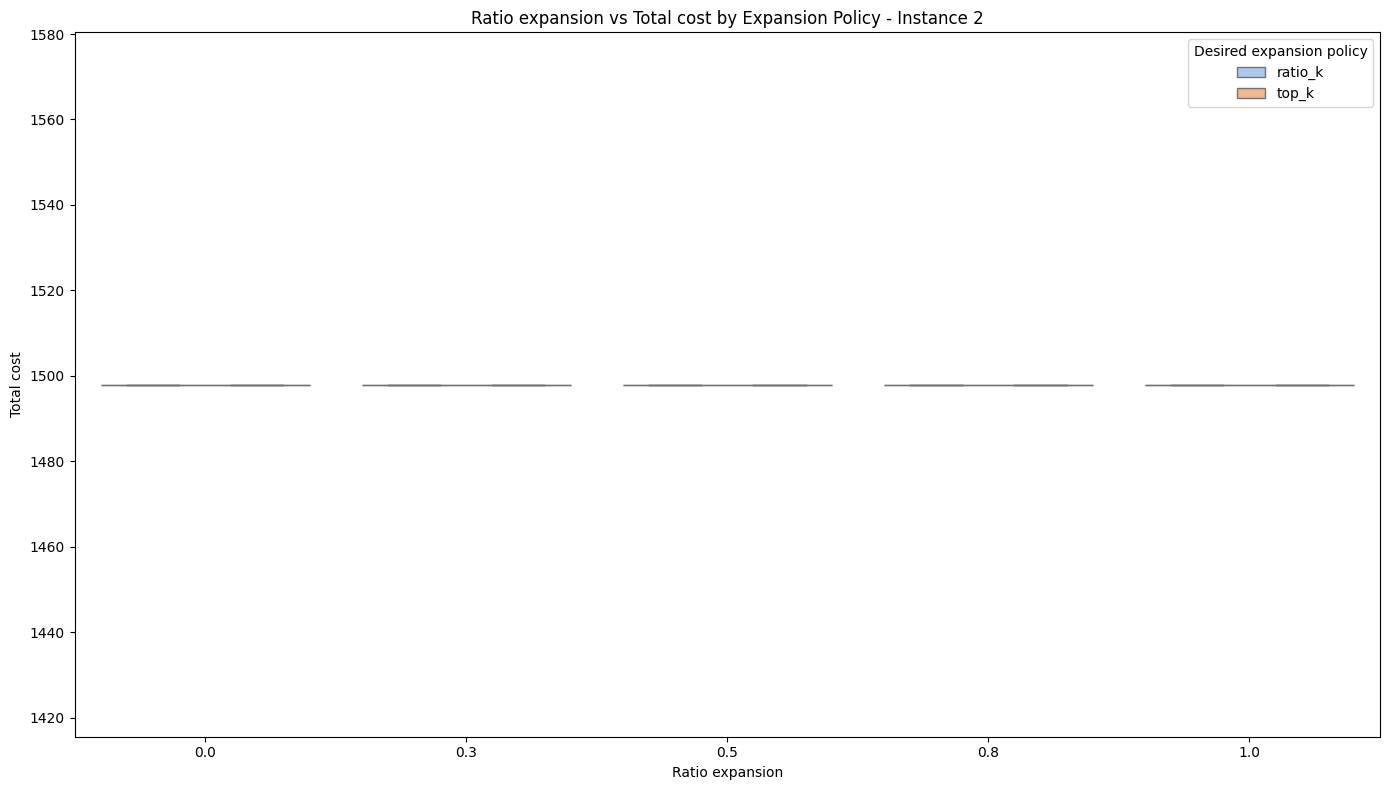

In [308]:
DV.expansion_vs_cost()

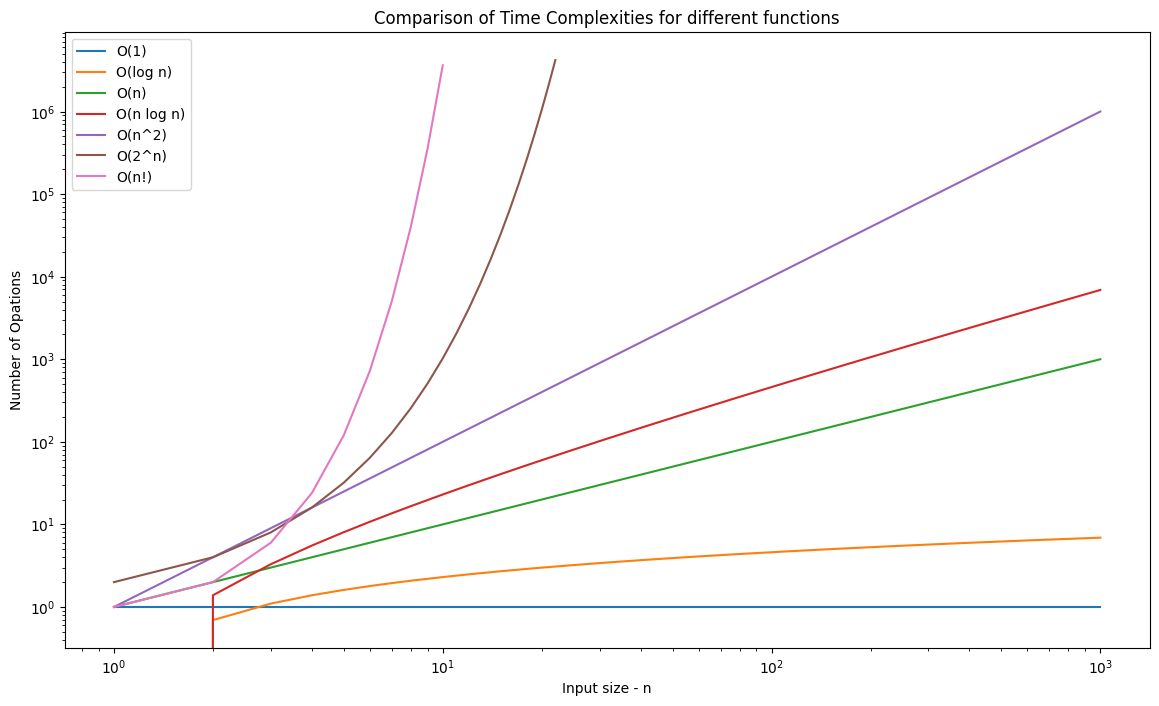

In [309]:
DV.plot_different_time_complexity()